# Phase 4: Transition Analysis

This notebook visualizes transition boundary characteristics from interpolation paths.

**Input Data:**
- `transitions.json`: Per-path divergence curves and transition metrics
- `interpolation_metadata.json`: Metadata about interpolation pairs

**Visualizations:**
1. Sharpness by key (bar chart)
2. Divergence curves for sample paths
3. t* distribution histogram
4. Sharpness vs total divergence scatter
5. Transition heatmap for safety_criticality

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import defaultdict

# Configuration
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 150
plt.rcParams['font.size'] = 10
sns.set_style('whitegrid')

# Paths
DATA_DIR = Path('/Users/kaiser/Projects/Masterarbeit/data/runs/classification_20260120')
FIGURE_DIR = DATA_DIR / 'figures'
FIGURE_DIR.mkdir(exist_ok=True)

## Load Data

In [2]:
# Load transitions data
with open(DATA_DIR / 'transitions.json', 'r') as f:
    transitions_data = json.load(f)

paths = transitions_data['paths']
key_stats = transitions_data['key_stats']
summary = transitions_data['summary']

print(f'Total paths: {len(paths)}')
print(f'Keys analyzed: {list(key_stats.keys())}')
print(f'Summary: {summary}')

Total paths: 136
Keys analyzed: ['pedestrians_present', 'traffic_situation', 'required_action', 'construction_activity', 'visual_degradation', 'road_type', 'time_of_day', 'occlusion_level', 'depth_complexity', 'safety_criticality', 'similar_object_confusion', 'traffic_signals_visible', 'weather']
Summary: {'total_paths': 136, 'total_with_transitions': 136, 'mean_sharpness': 0.31860157299211744, 'mean_divergence': 0.1683139768449546}


In [3]:
# Load interpolation metadata
with open(DATA_DIR / 'interpolation_metadata.json', 'r') as f:
    interp_metadata = json.load(f)

print(f'Interpolation metadata keys: {list(interp_metadata.keys()) if isinstance(interp_metadata, dict) else "list"}')

Interpolation metadata keys: list


## 1. Sharpness by Key

Bar chart showing mean sharpness per key, sorted in descending order. Higher sharpness indicates more abrupt transitions.

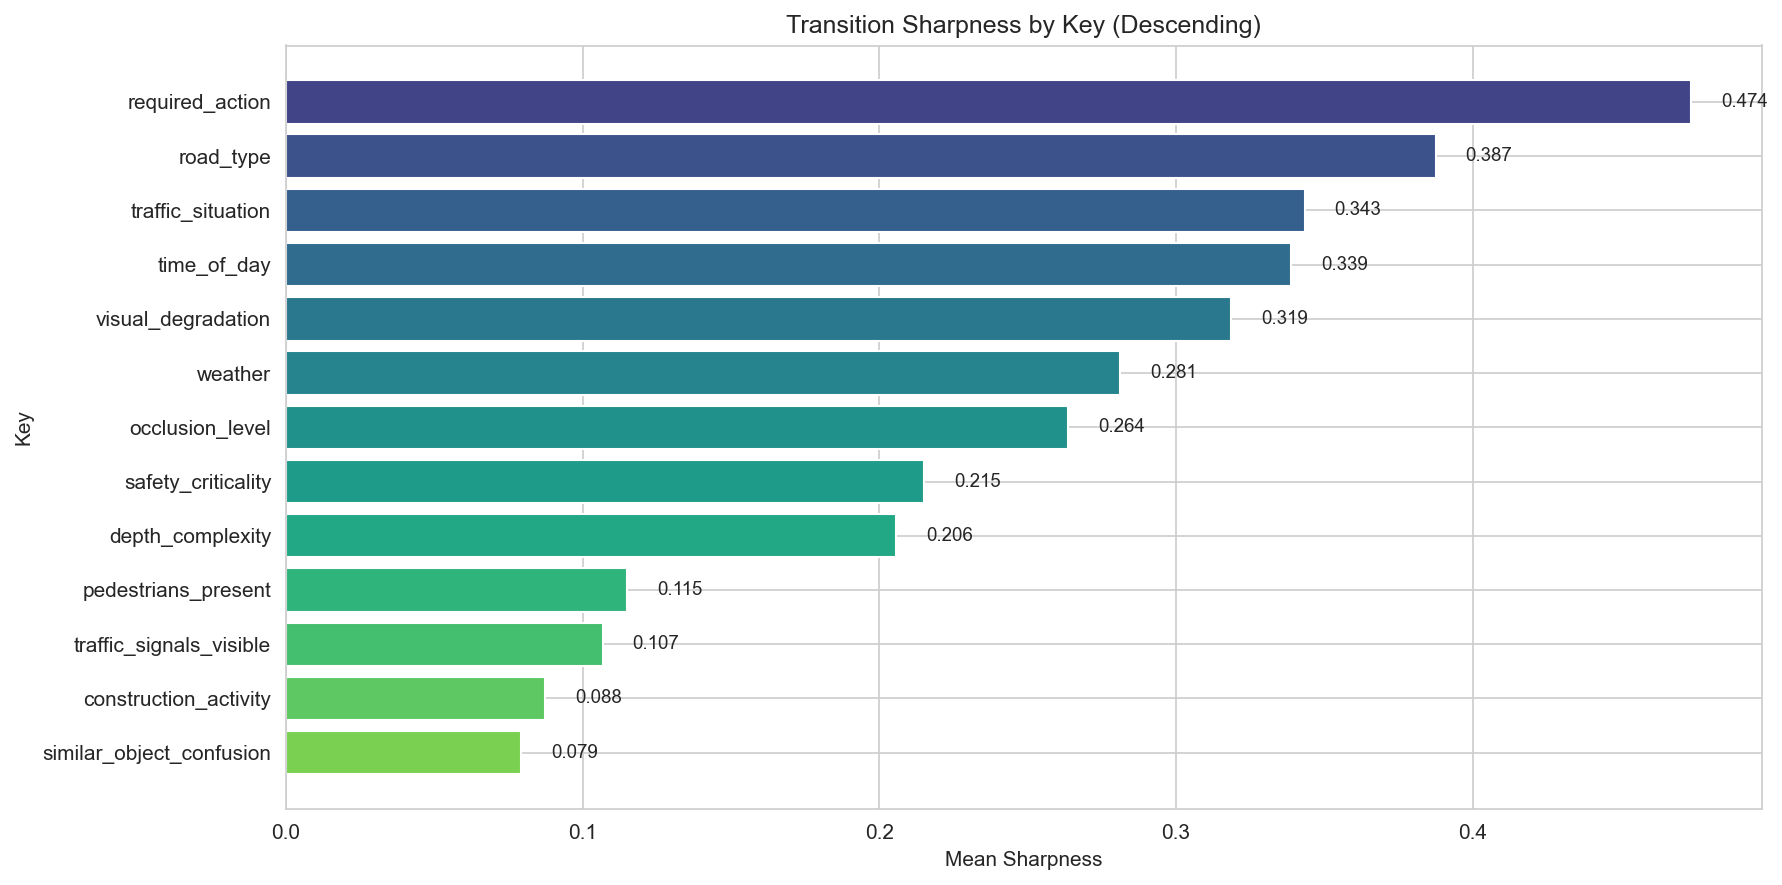

Saved: /Users/kaiser/Projects/Masterarbeit/data/runs/classification_20260120/figures/04_sharpness_by_key.png


In [4]:
# Extract key names and mean sharpness values
key_names = list(key_stats.keys())
mean_sharpness = [key_stats[k]['mean_sharpness'] for k in key_names]

# Sort by sharpness descending
sorted_indices = np.argsort(mean_sharpness)[::-1]
sorted_keys = [key_names[i] for i in sorted_indices]
sorted_sharpness = [mean_sharpness[i] for i in sorted_indices]

# Create bar chart
fig, ax = plt.subplots(figsize=(12, 6))

colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(sorted_keys)))
bars = ax.barh(range(len(sorted_keys)), sorted_sharpness, color=colors)

ax.set_yticks(range(len(sorted_keys)))
ax.set_yticklabels(sorted_keys)
ax.set_xlabel('Mean Sharpness')
ax.set_ylabel('Key')
ax.set_title('Transition Sharpness by Key (Descending)')
ax.invert_yaxis()

# Add value labels
for i, (bar, val) in enumerate(zip(bars, sorted_sharpness)):
    ax.text(val + 0.01, i, f'{val:.3f}', va='center', fontsize=9)

plt.tight_layout()
fig.savefig(FIGURE_DIR / '04_sharpness_by_key.png', bbox_inches='tight')
plt.show()

print(f'Saved: {FIGURE_DIR / "04_sharpness_by_key.png"}')

## 2. Divergence Curves

Plot divergence (delta(t)) vs interpolation parameter t for 3 sample paths. Vertical lines mark detected transitions.

In [5]:
# Select 3 diverse sample paths (different keys, varying sharpness)
# Sort paths by sharpness and pick low, medium, high
path_sharpness = [(i, p['sharpness'], p['key']) for i, p in enumerate(paths)]
path_sharpness.sort(key=lambda x: x[1])

n_paths = len(path_sharpness)
sample_indices = [
    path_sharpness[n_paths // 4][0],      # Low sharpness
    path_sharpness[n_paths // 2][0],      # Medium sharpness
    path_sharpness[3 * n_paths // 4][0]   # High sharpness
]

print('Selected sample paths:')
for idx in sample_indices:
    p = paths[idx]
    print(f'  {p["key"]}: {p["value_a"]} -> {p["value_b"]} (sharpness={p["sharpness"]:.3f})')

Selected sample paths:
  traffic_situation: complex -> critical (sharpness=0.274)
  visual_degradation: glare -> none (sharpness=0.324)
  road_type: highway -> intersection (sharpness=0.386)


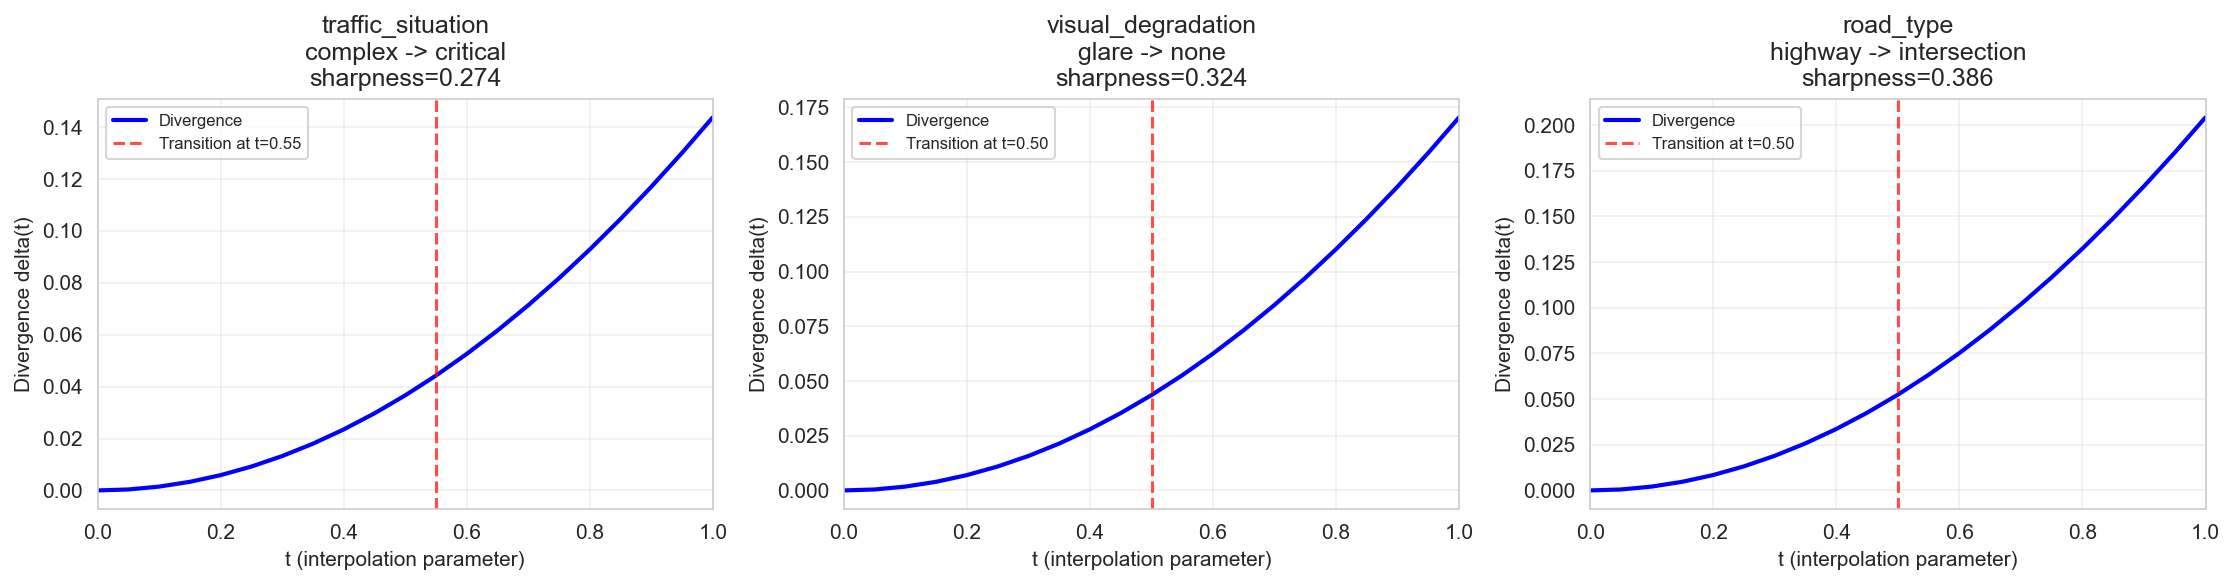

Saved: /Users/kaiser/Projects/Masterarbeit/data/runs/classification_20260120/figures/04_divergence_curves.png


In [6]:
# Plot divergence curves
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, idx in zip(axes, sample_indices):
    p = paths[idx]
    t_values = p['t_values']
    divergence = p['divergence']
    
    # Plot divergence curve
    ax.plot(t_values, divergence, 'b-', linewidth=2, label='Divergence')
    
    # Mark transitions with vertical lines
    for trans in p['transitions']:
        ax.axvline(trans['t'], color='r', linestyle='--', alpha=0.7,
                   label=f'Transition at t={trans["t"]:.2f}')
    
    ax.set_xlabel('t (interpolation parameter)')
    ax.set_ylabel('Divergence delta(t)')
    ax.set_title(f'{p["key"]}\n{p["value_a"]} -> {p["value_b"]}\nsharpness={p["sharpness"]:.3f}')
    ax.legend(loc='upper left', fontsize=8)
    ax.set_xlim(0, 1)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
fig.savefig(FIGURE_DIR / '04_divergence_curves.png', bbox_inches='tight')
plt.show()

print(f'Saved: {FIGURE_DIR / "04_divergence_curves.png"}')

## 3. t* Distribution

Histogram of boundary positions (t*) across all paths. Shows where transitions typically occur along interpolation paths.

In [7]:
# Extract all t_star values
t_star_values = [p['t_star'] for p in paths]

# Also extract transition t values (actual detected transitions)
transition_t_values = []
for p in paths:
    for trans in p['transitions']:
        transition_t_values.append(trans['t'])

print(f't* values: {len(t_star_values)} (range: [{min(t_star_values):.2f}, {max(t_star_values):.2f}])')
print(f'Transition t values: {len(transition_t_values)} (range: [{min(transition_t_values):.2f}, {max(transition_t_values):.2f}])')

t* values: 136 (range: [1.00, 1.00])
Transition t values: 136 (range: [0.50, 0.55])


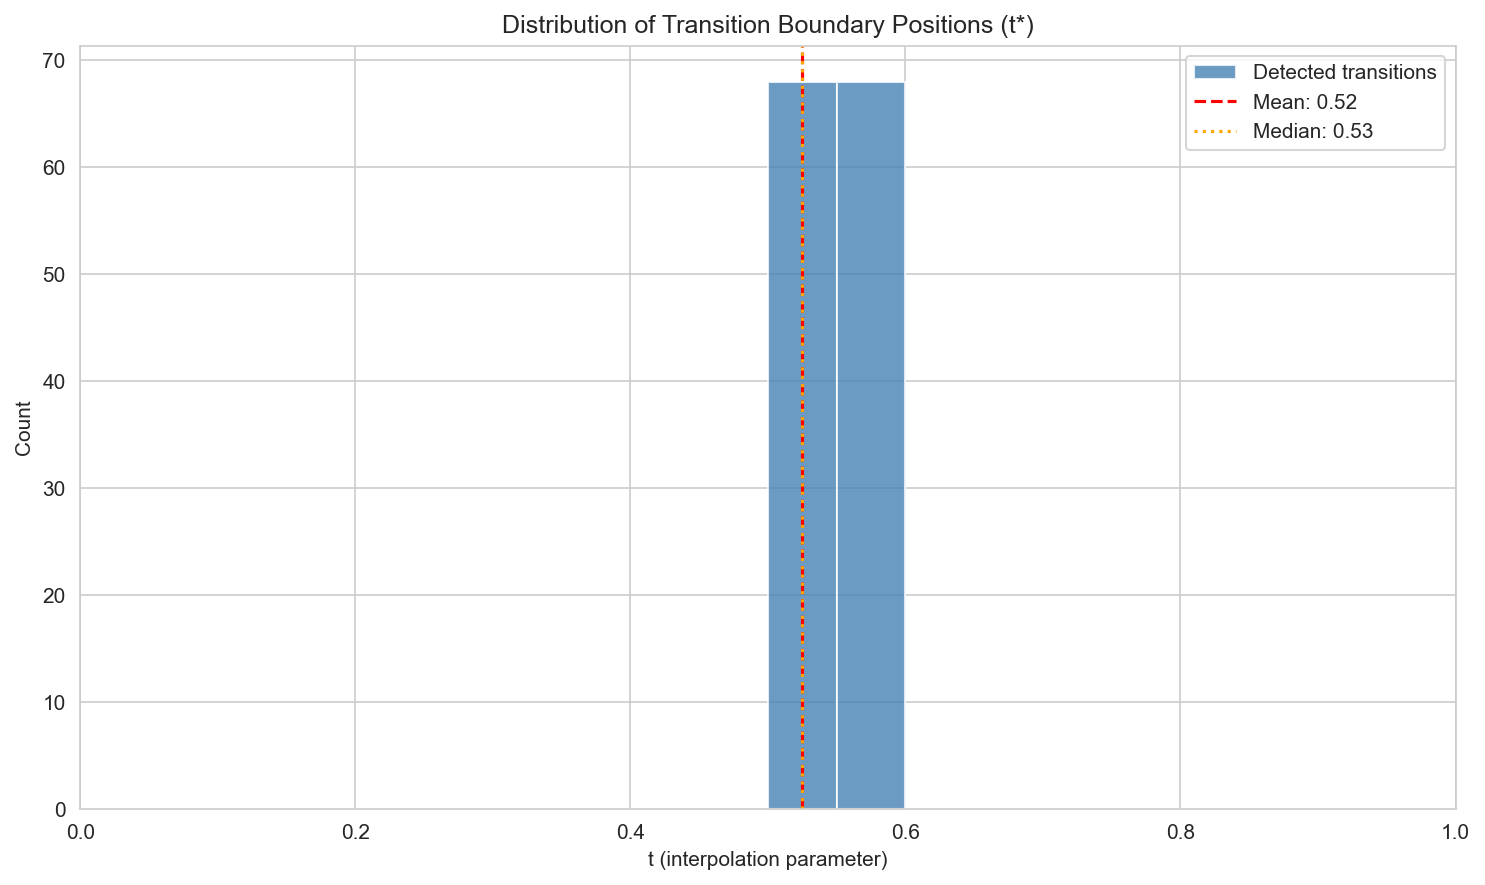

Saved: /Users/kaiser/Projects/Masterarbeit/data/runs/classification_20260120/figures/04_t_star_distribution.png
Mean transition position: 0.525
Median transition position: 0.525


In [8]:
# Create histogram of transition positions
fig, ax = plt.subplots(figsize=(10, 6))

# Histogram of actual transition positions (where NN classifier switches)
ax.hist(transition_t_values, bins=20, range=(0, 1), color='steelblue', 
        edgecolor='white', alpha=0.8, label='Detected transitions')

ax.set_xlabel('t (interpolation parameter)')
ax.set_ylabel('Count')
ax.set_title('Distribution of Transition Boundary Positions (t*)')
ax.set_xlim(0, 1)
ax.legend()

# Add summary statistics
mean_t = np.mean(transition_t_values)
median_t = np.median(transition_t_values)
ax.axvline(mean_t, color='red', linestyle='--', label=f'Mean: {mean_t:.2f}')
ax.axvline(median_t, color='orange', linestyle=':', label=f'Median: {median_t:.2f}')
ax.legend()

plt.tight_layout()
fig.savefig(FIGURE_DIR / '04_t_star_distribution.png', bbox_inches='tight')
plt.show()

print(f'Saved: {FIGURE_DIR / "04_t_star_distribution.png"}')
print(f'Mean transition position: {mean_t:.3f}')
print(f'Median transition position: {median_t:.3f}')

## 4. Sharpness vs Total Divergence

Scatter plot showing the relationship between sharpness and total divergence for all paths, colored by key.

In [9]:
# Extract data for scatter plot
sharpness_vals = [p['sharpness'] for p in paths]
divergence_vals = [p['total_divergence'] for p in paths]
key_vals = [p['key'] for p in paths]

# Create color mapping for keys
unique_keys = list(set(key_vals))
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_keys)))
key_to_color = {k: colors[i] for i, k in enumerate(unique_keys)}

print(f'Unique keys: {len(unique_keys)}')

Unique keys: 13


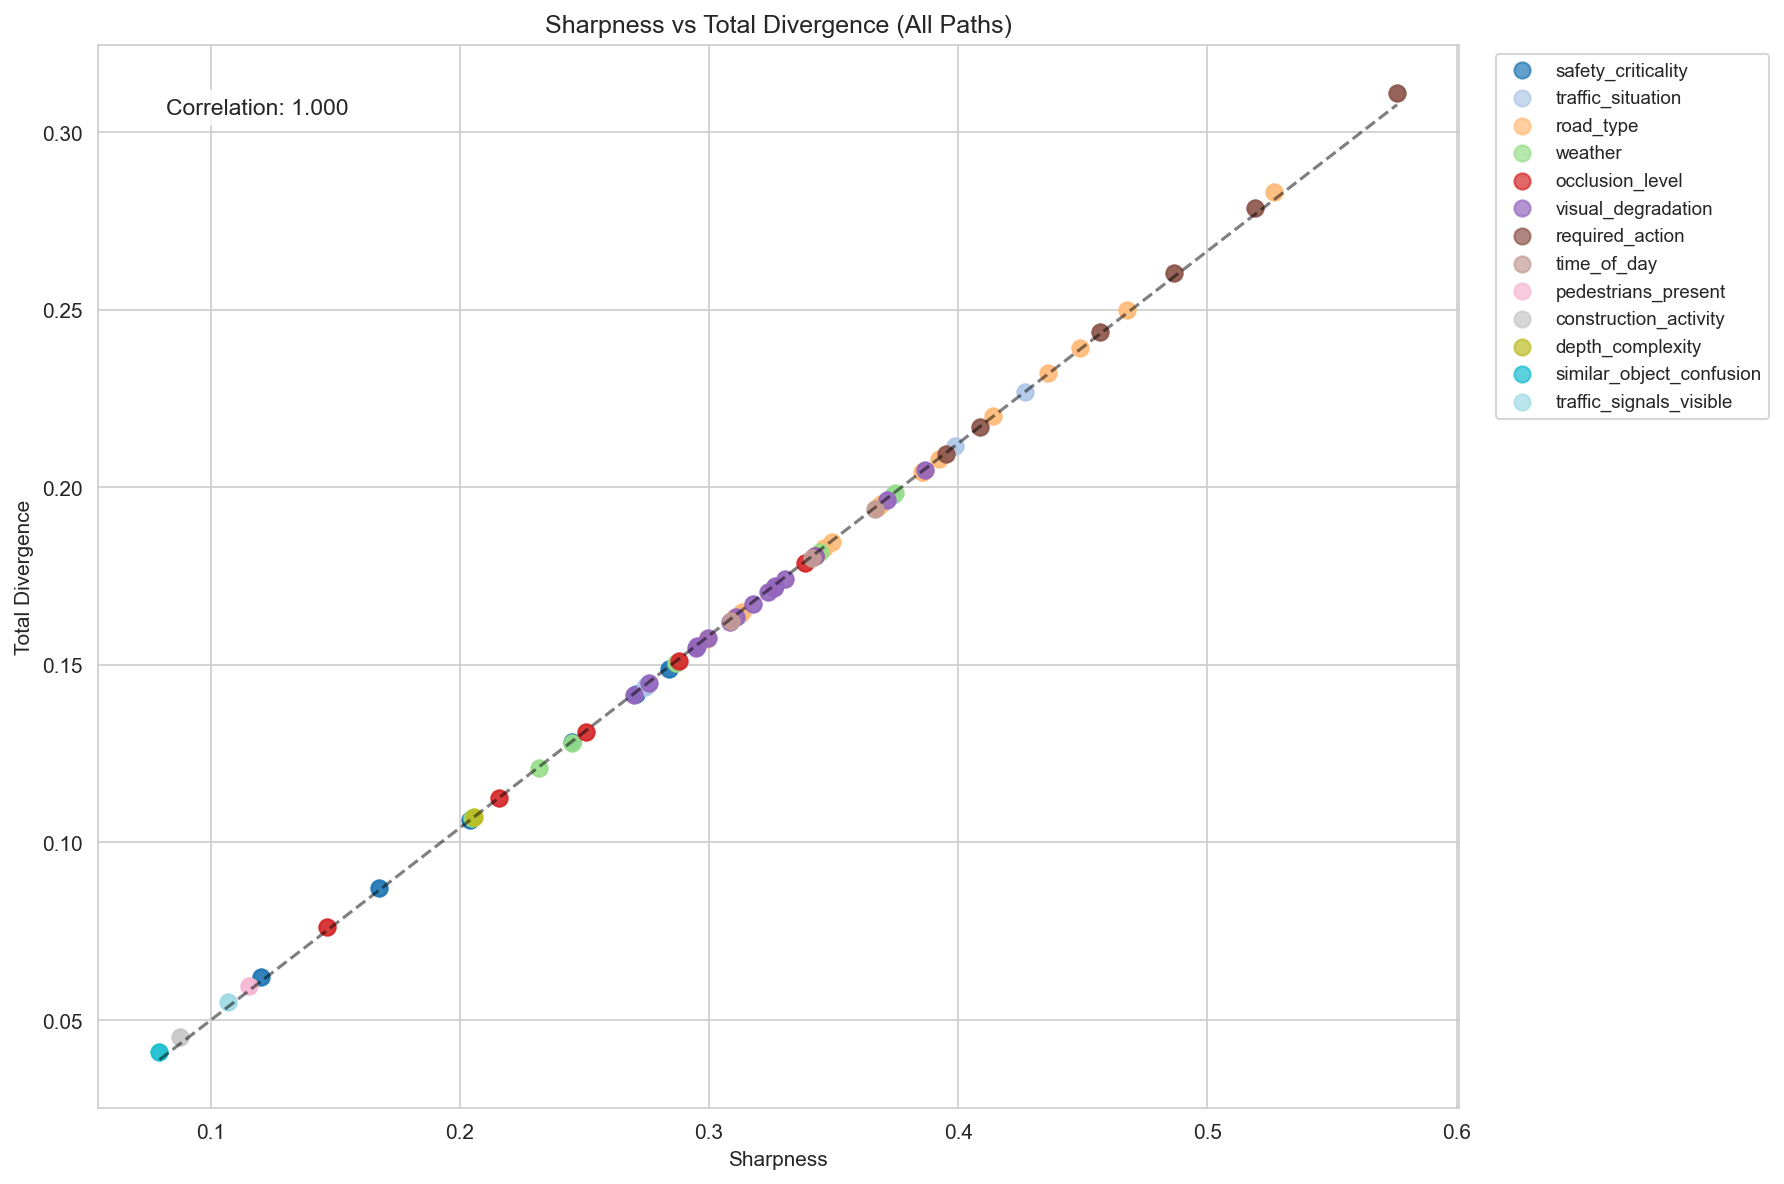

Saved: /Users/kaiser/Projects/Masterarbeit/data/runs/classification_20260120/figures/04_sharpness_vs_divergence.png
Pearson correlation: 0.9999


In [10]:
# Create scatter plot
fig, ax = plt.subplots(figsize=(12, 8))

for key in unique_keys:
    mask = [k == key for k in key_vals]
    x = [sharpness_vals[i] for i, m in enumerate(mask) if m]
    y = [divergence_vals[i] for i, m in enumerate(mask) if m]
    ax.scatter(x, y, c=[key_to_color[key]], label=key, alpha=0.7, s=60)

ax.set_xlabel('Sharpness')
ax.set_ylabel('Total Divergence')
ax.set_title('Sharpness vs Total Divergence (All Paths)')
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=9)

# Add trend line
z = np.polyfit(sharpness_vals, divergence_vals, 1)
p_fit = np.poly1d(z)
x_range = np.linspace(min(sharpness_vals), max(sharpness_vals), 100)
ax.plot(x_range, p_fit(x_range), 'k--', alpha=0.5, label='Linear fit')

# Compute correlation
corr = np.corrcoef(sharpness_vals, divergence_vals)[0, 1]
ax.text(0.05, 0.95, f'Correlation: {corr:.3f}', transform=ax.transAxes,
        fontsize=11, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
fig.savefig(FIGURE_DIR / '04_sharpness_vs_divergence.png', bbox_inches='tight')
plt.show()

print(f'Saved: {FIGURE_DIR / "04_sharpness_vs_divergence.png"}')
print(f'Pearson correlation: {corr:.4f}')

## 5. Transition Heatmap for Safety Criticality

Heatmap showing which value pairs have sharp transitions for the safety_criticality key.

In [11]:
# Extract paths for safety_criticality
safety_paths = [p for p in paths if p['key'] == 'safety_criticality']
print(f'Safety criticality paths: {len(safety_paths)}')

# Get unique values
safety_values = set()
for p in safety_paths:
    safety_values.add(p['value_a'])
    safety_values.add(p['value_b'])
safety_values = sorted(list(safety_values))
print(f'Safety values: {safety_values}')

Safety criticality paths: 12
Safety values: ['tier1_catastrophic', 'tier2_severe', 'tier3_moderate', 'tier4_minor']


In [12]:
# Build sharpness matrix
n_values = len(safety_values)
sharpness_matrix = np.zeros((n_values, n_values))
value_to_idx = {v: i for i, v in enumerate(safety_values)}

for p in safety_paths:
    i = value_to_idx[p['value_a']]
    j = value_to_idx[p['value_b']]
    sharpness_matrix[i, j] = p['sharpness']

print(f'Sharpness matrix shape: {sharpness_matrix.shape}')

Sharpness matrix shape: (4, 4)


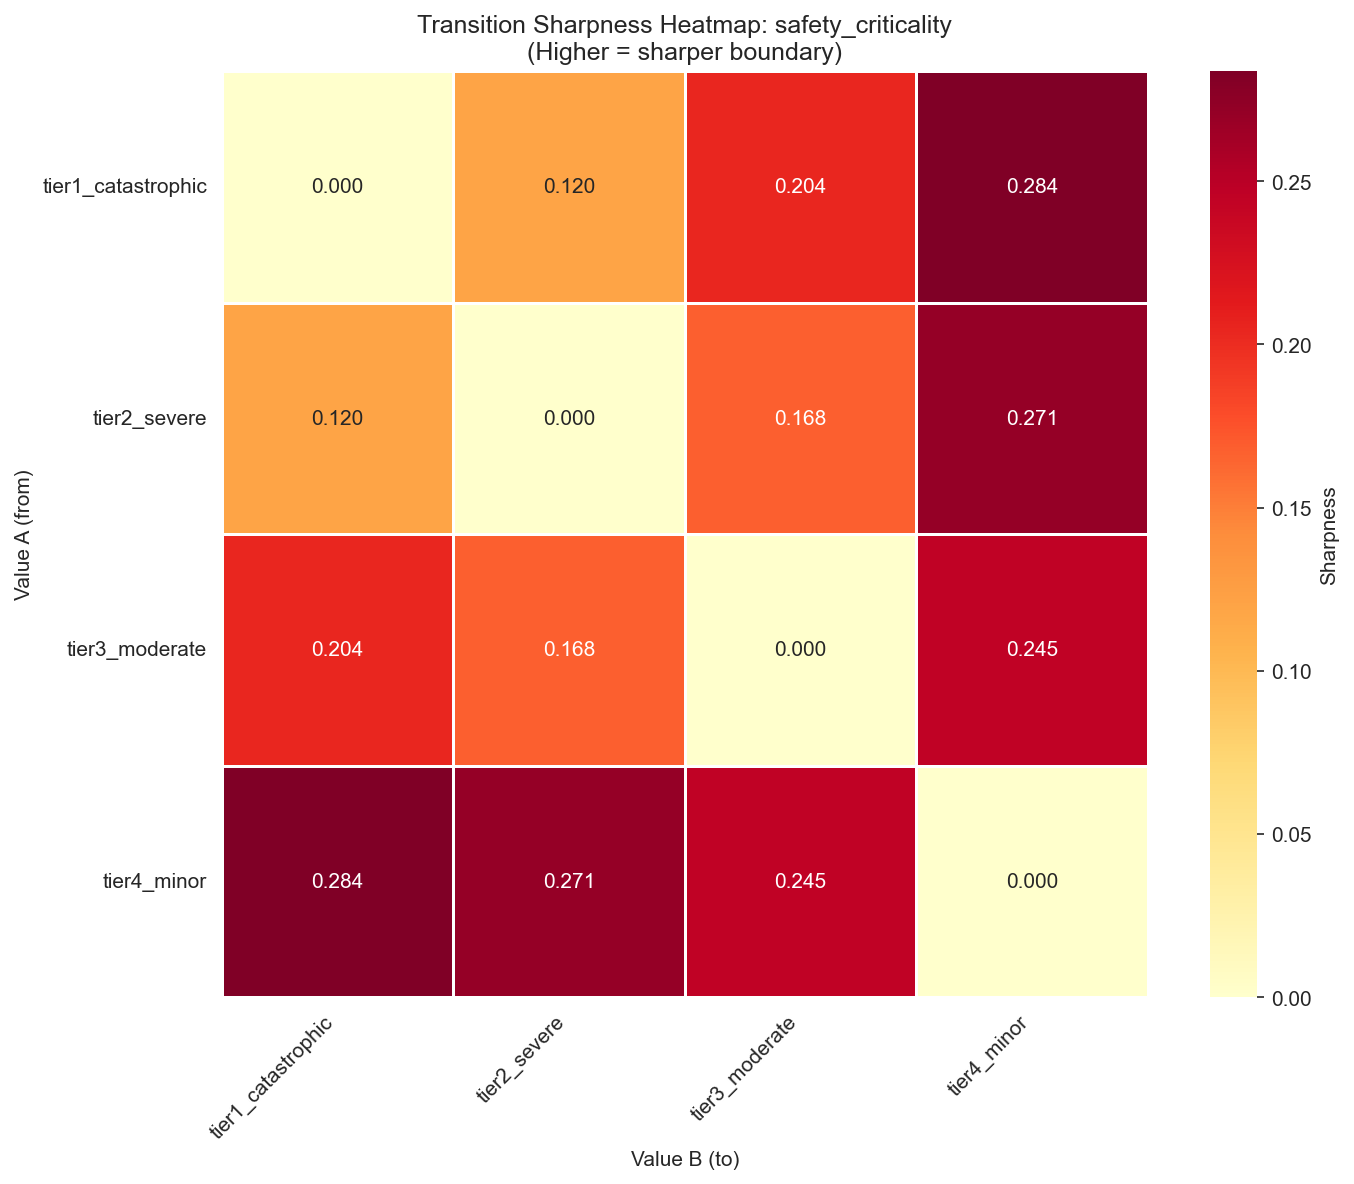

Saved: /Users/kaiser/Projects/Masterarbeit/data/runs/classification_20260120/figures/04_transition_heatmap_safety.png


In [13]:
# Create heatmap
fig, ax = plt.subplots(figsize=(10, 8))

# Use a diverging colormap centered around the mean
sns.heatmap(sharpness_matrix,
            xticklabels=safety_values,
            yticklabels=safety_values,
            annot=True,
            fmt='.3f',
            cmap='YlOrRd',
            square=True,
            ax=ax,
            cbar_kws={'label': 'Sharpness'},
            linewidths=0.5)

ax.set_xlabel('Value B (to)')
ax.set_ylabel('Value A (from)')
ax.set_title('Transition Sharpness Heatmap: safety_criticality\n(Higher = sharper boundary)')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

plt.tight_layout()
fig.savefig(FIGURE_DIR / '04_transition_heatmap_safety.png', bbox_inches='tight')
plt.show()

print(f'Saved: {FIGURE_DIR / "04_transition_heatmap_safety.png"}')

## Summary

Key observations from transition analysis:

1. **Sharpness by Key**: Shows which attribute types have the sharpest transition boundaries
2. **Divergence Curves**: Illustrates how divergence accumulates along interpolation paths
3. **t* Distribution**: Reveals the typical positions where transitions occur (often near midpoint)
4. **Sharpness vs Divergence**: Correlation between boundary sharpness and total divergence
5. **Safety Heatmap**: Identifies which safety tier transitions have the sharpest boundaries

In [14]:
# List generated figures
print('Generated figures:')
for f in sorted(FIGURE_DIR.glob('04_*.png')):
    print(f'  {f.name}')

Generated figures:
  04_divergence_curves.png
  04_sharpness_by_key.png
  04_sharpness_vs_divergence.png
  04_t_star_distribution.png
  04_transition_heatmap_safety.png
